In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from BayesOpt.GaussianProcess import GaussianProcess
from BayesOpt.utils.plot import *

%matplotlib inline
matplotlib.rcParams.update({
    "figure.figsize": (12, 4),
    "axes.spines.top": False,
    "axes.spines.right": False
})

np.random.seed(42)

# Gaussian Processes and Kernels in Machine Learning

In this Jupyter notebook, we will explore Gaussian Processes (GPs) and their use in machine learning. We will replicate Figures 2.2 and 2.5 from Rasmussen & Williams' book "Gaussian Processes for Machine Learning" (2006). This notebook will guide you through the concepts of Gaussian Processes, kernels, and how different kernels affect the behavior of GPs.

### Motivating Gaussian Processes with an Example

To better understand the motivation behind Gaussian Processes, let's first consider a plot with scatterpoints representing data points with an unknown relationship between the x variable and the y variable. Our goal is to model this relationship.

(-1.2, 1.2)

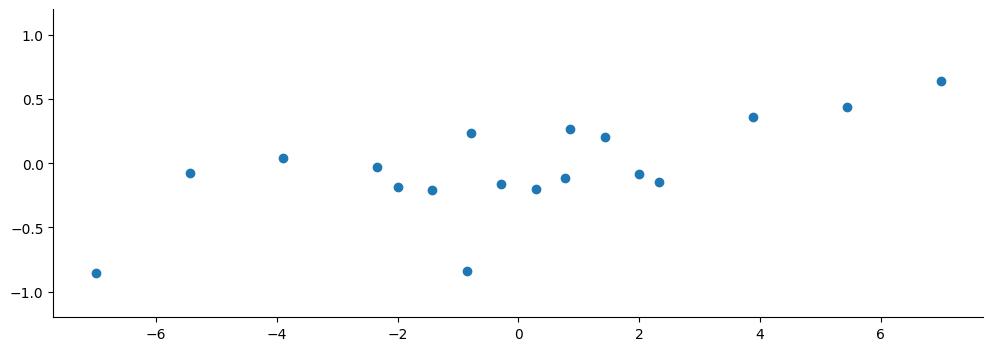

In [2]:
xtrain, xtest = (
    np.sort(np.hstack([np.linspace(-7, 7, 10), np.linspace(-2, 2, 8)])),
    np.linspace(-7,7,100)
)
ytrain = np.array(
    [x*np.random.uniform(-0.1,0.1) + np.random.normal(x/10,0.3) for x in xtrain]
)
fig, ax = plt.subplots(1, 1)
ax.plot(xtrain, ytrain, 'o')
ax.set_ylim(-1.2, 1.2)

As a first step, we might try fitting a linear model to the data.

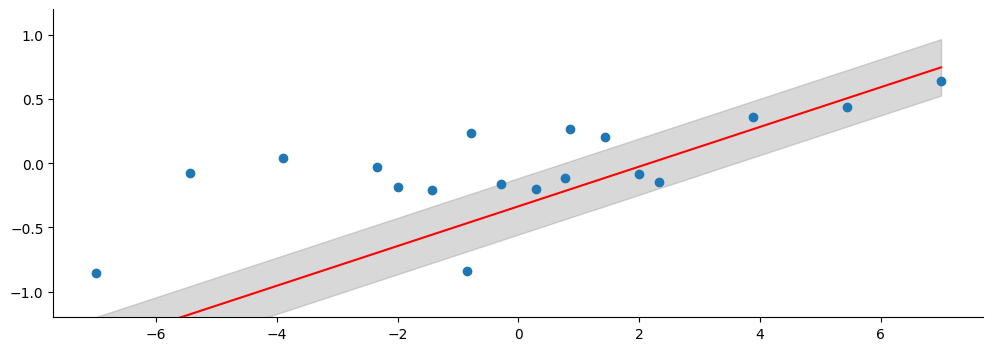

In [3]:
# random subset of values
index = np.sort(np.random.choice(len(xtrain), 3, replace=False))
xsample, ysample = xtrain[index], ytrain[index] 

# lin reg
slope, intercept, r_value, p_value, std_err = stats.linregress(
    xsample, ysample
)

# tscore
alpha = 0.05
t_score = stats.t.ppf(1 - alpha / 2, len(xtrain) - 2)

# regline
regression_line = slope * xtrain + intercept
# plt.scatter(xsample, ysample, label='Data points', color='blue')
ax.plot(xtrain, regression_line, label='Regression line', color='red')
ax.fill_between(
    xtrain, 
    regression_line - t_score*std_err, 
    regression_line + t_score*std_err, 
    color='gray', 
    alpha=0.3
)
fig

While the linear fit may capture some of the overall trend, it might not fully represent the underlying relationship between the x and y variables. We could also try fitting a polynomial model to better capture the non-linear patterns in the data.

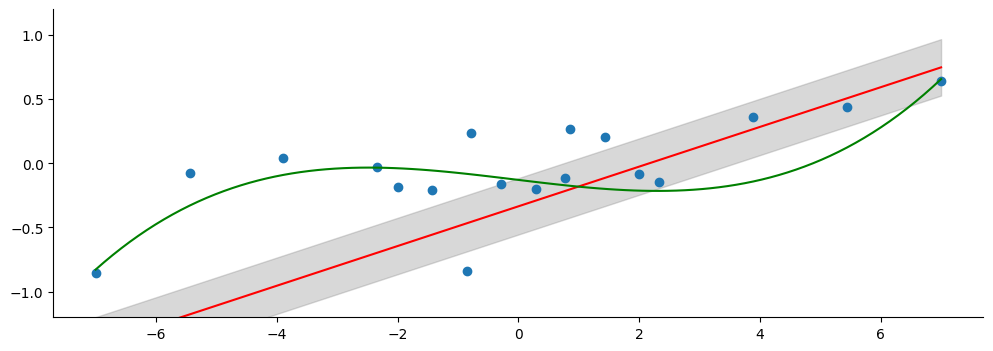

In [4]:
# random subset of values
index = np.sort(np.random.choice(len(xtrain), 5, replace=False))
xsample, ysample = xtrain[index], ytrain[index] 

coefficients = np.polyfit(xsample, ysample, 3)

polynomial = np.poly1d(coefficients)

xp = np.linspace(xtrain[0], xtrain[-1], 100)
yp = polynomial(xp)

ax.plot(xp, yp, label='Polynomial line', color='green')
fig

With a polynomial fit, we can capture more complex relationships, but choosing the appropriate degree for the polynomial becomes a challenge. Additionally, polynomial fits do not provide uncertainty estimates for predictions, which can be crucial for decision-making in various applications.

This is where Gaussian Processes come in. GPs provide a flexible and powerful way of modeling the unknown relationship between the x and y variables, without having to commit to a specific functional form. Instead, GPs represent a distribution over functions, which allows us to capture a wide range of possible relationships between the input and output variables.

Furthermore, Gaussian Processes not only provide point estimates (the mean) for a given input but also an estimate of the uncertainty (the variance) associated with that prediction. This uncertainty can be crucial for decision-making in various applications, such as optimization, reinforcement learning, or active learning, where understanding the model's confidence in its predictions is essential.

In the following sections, we will dive deeper into Gaussian Processes and explore how they can be used to model complex relationships between input and output variables while providing uncertainty estimates for predictions.


## Gaussian Processes

Gaussian Processes are a tool for non-parametric regression and classification in machine learning. A GP is a collection of random variables, any finite number of which have a joint Gaussian distribution. In the context of regression, a GP can be thought of as a distribution over functions, where each function maps input data points to output values. The prior distribution of the GP is determined by its mean function and covariance function (also known as the kernel function).

A Gaussian Process is defined as:

$$f(x) \sim \mathcal{GP}(m(x), k(x, x'))$$

Where $m(x)$ is the mean function and $k(x, x')$ is the covariance function, ie.

\begin{aligned}
m(\mathbf{x}) & =\mathbb{E}[f(\mathbf{x})] \\
k\left(\mathbf{x}, \mathbf{x}^{\prime}\right) & =\mathbb{E}\left[(f(\mathbf{x})-m(\mathbf{x}))\left(f\left(\mathbf{x}^{\prime}\right)-m\left(\mathbf{x}^{\prime}\right)\right)\right]
\end{aligned}

In most cases, the mean function is assumed to be zero, and the kernel function is responsible for defining the shape and smoothness of the functions generated by the GP.

In Gaussian Processes, instead of learning fixed model parameters as in parametric methods, we infer a distribution over the space of functions that best fit the observed data. This non-parametric approach allows for increased flexibility and adaptability to the underlying structure of the data. As a result, Gaussian Processes can model a wide variety of functions and are particularly useful for situations where there is limited data, the relationship between the input and output variables is complex, or the underlying function is smooth.

One of the key advantages of Gaussian Processes is their ability to provide uncertainty estimates for predictions. Since a GP is a distribution over functions, it not only provides a point estimate (the mean) for a given input, but also an estimate of the uncertainty (the variance) associated with that prediction. This uncertainty can be crucial for decision-making in various applications, such as optimization, reinforcement learning, or active learning, where understanding the model's confidence in its predictions is essential.

Before we dive into kernel functions, let's take a look at some plots of an untrained Gaussian Process with a square exponential kernel. We will see how we can draw an infinite number of functions from the GP prior, which represents our uncertainty about the true function before observing any data points.

In [5]:
instance = GaussianProcess()
fig, ax = plt.subplots(1,2, figsize=(16,4));
plt.close()

The Gaussian Process prior represents our uncertainty about the true function before observing any data points, efined by the mean function $m(x)$ and the covariance function (or kernel) $k(x, x')$. In most cases, the mean function is assumed to be zero, so the behavior of the prior is primarily determined by the choice of kernel function and its hyperparameters.

A key aspect of the Gaussian Process prior is that it encodes the smoothness, periodicity, and other characteristics of the functions that can be sampled from it. These characteristics depend on the chosen kernel function and its hyperparameters. For example, a square exponential kernel (also known as the Radial Basis Function kernel) generates smooth functions, while a Matérn kernel can generate functions with varying degrees of smoothness depending on its hyperparameters.

The kernel function also dictates the degree of correlation between function values at different input points. If the kernel function has a large value for a given pair of input points, it implies that the function values at these points are highly correlated, and the function will change smoothly between these points. On the other hand, if the kernel function has a small value for a given pair of input points, it implies that the function values at these points are less correlated, and the function may change more rapidly between these points.

In summary, the behavior of the Gaussian Process prior is determined by the choice of kernel function and its hyperparameters, which encode the smoothness, periodicity, and other characteristics of the functions that can be sampled from the prior. Understanding the behavior of the GP prior is crucial for choosing an appropriate kernel function and hyperparameters, as they directly affect the quality of predictions made by the model and its ability to generalize to unseen data points.


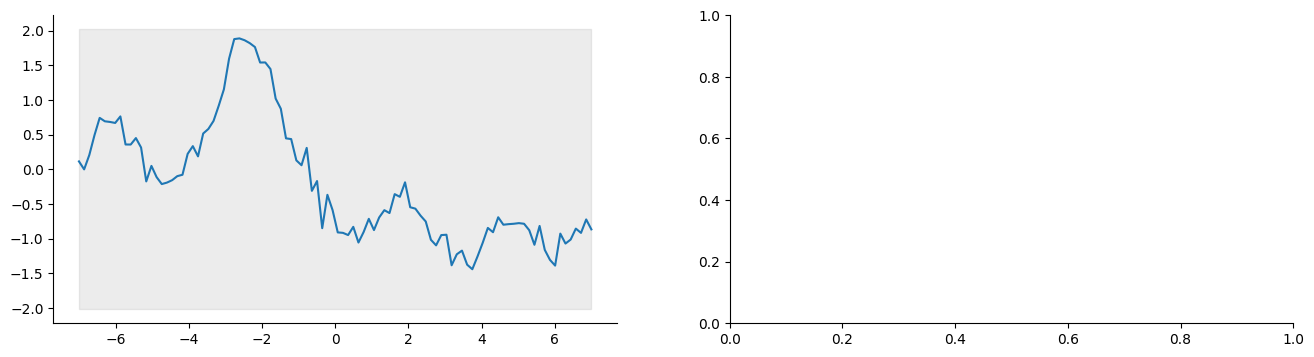

In [6]:
yprior, vprior = instance.get_prior_trajectories(X=xtest, num_trajectories=1)

ax[0].plot(xtest, yprior)
ax[0].fill_between(
    xtest, 
    0 - 2 * vprior**0.5, 
    0 + 2 * vprior**0.5,
    color="gray", 
    alpha=0.15
)
fig

As we start to train the Gaussian Process on individual data points, we will see in subsequent plots how the uncertainty collapses around those points. This happens because the posterior predictions of the model take into account the already seen data points, updating our beliefs about the true underlying function.

In [7]:
xtrainc, ytrainc = list(xtrain).copy(), list(ytrain).copy()
xsample, ysample = [], []

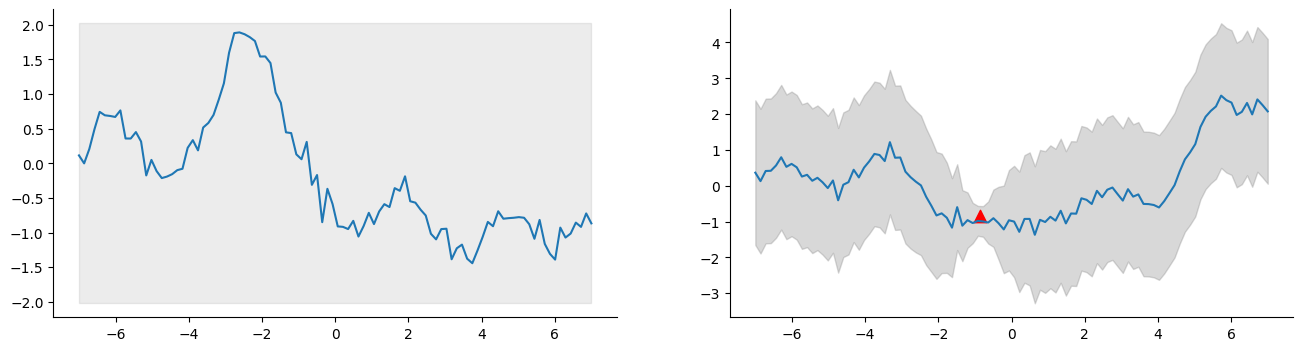

In [8]:
index = np.sort(np.random.choice(len(xtrainc), 1, replace=False))
xsample += [xtrainc.pop(index[0])]
ysample += [ytrainc.pop(index[0])]

instance.fit(X=np.array(xsample), y=np.array(ysample))
ypost, vpost = instance.get_posterior_trajectories(X=xtest, num_trajectories=1, cholesky=True)

ax[1].clear()
ax[1].plot(xtest, ypost[:,0])
ax[1].fill_between(
    xtest, 
    np.mean(ypost, axis=1) - 2 * vpost**0.5, 
    np.mean(ypost, axis=1) + 2 * vpost**0.5,
    color="gray", 
    alpha=0.3
)

ax[1].scatter(xsample, ysample, marker="^", s=80, c="r")
fig

#### Rasmussen & Williams (2006) Figure 2.2

As we have discussed earlier, Gaussian Processes provide a flexible and powerful way to model uncertainty about the true function. When we observe new data points, the GP model updates its beliefs about the underlying function, collapsing uncertainty around the observed points. This is because the posterior predictions of the model take into account the already seen data points.

To illustrate this, let's replicate Figure 2.2 from Rasmussen and Williams' book "Gaussian Processes for Machine Learning" (2006). This figure shows a few sample functions drawn from both the prior distribution and the posterior distribution of a Gaussian Process.

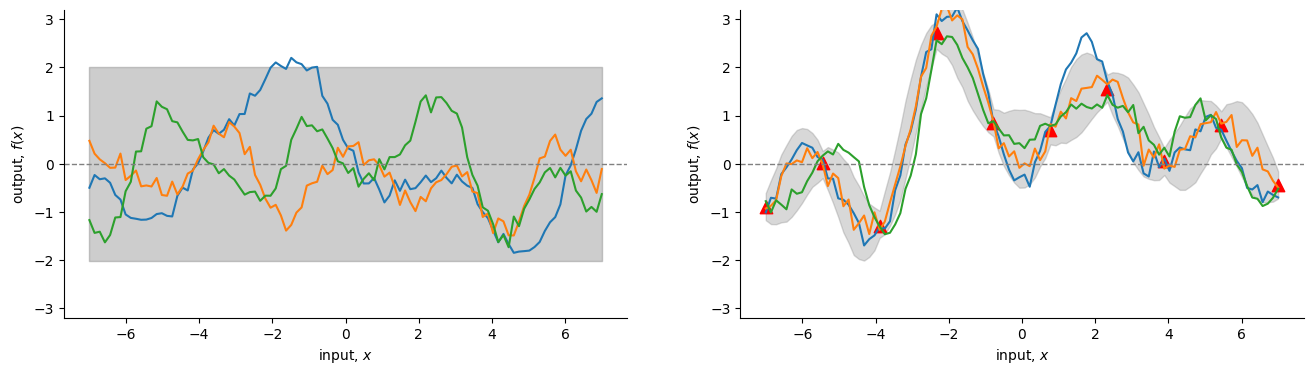

In [9]:
instance = GaussianProcess()
xtrain, xtest = np.linspace(-7, 7, 10), np.linspace(-7,7,100)

#----------% Figure 2.2 %----------#

# Single prior trajectory to build posterior, draw three posterior trajectories (using Cholesky)
y1, _ = instance.get_prior_trajectories(X=xtrain, num_trajectories=1)
# Three trajectories using priors
y3, vprior = instance.get_prior_trajectories(X=xtest, num_trajectories=3)
# Fit prior trajectory to build posterior
instance.fit(X=xtrain, y=y1)
# Get 100 posterior trajectories for `true` averages
ymean, vmean = instance.get_posterior_trajectories(
    X=xtest, 
    num_trajectories=100, 
    cholesky=True
)
# Get 3 posterior trajectories to plot
ypost, vpost = instance.get_posterior_trajectories(
    X=xtest, 
    num_trajectories=3, 
    cholesky=True
)
# Plot Figure 2.2
fig22(xtrain, xtest, y1, y3, vprior, ypost, ymean, vmean)

As we can see in the figure, the functions drawn from the prior distribution represent our initial uncertainty about the true function before observing any data points. Once we have observed some data points, the functions drawn from the posterior distribution capture the updated beliefs about the underlying function. The uncertainty in the posterior distribution collapses around the observed data points, while still allowing for some uncertainty in the regions where we have not observed any data.

This example demonstrates the ability of Gaussian Processes to model complex relationships between input and output variables while providing uncertainty estimates for predictions. As we continue to explore Gaussian Processes and their use in machine learning, we will delve deeper into the choice of kernel functions and their impact on the behavior of GPs.

## Kernel Functions

A kernel function, or covariance function, is a positive semi-definite function that measures the similarity between input data points. The choice of kernel function has a significant impact on the behavior of the Gaussian Process. Some commonly used kernel functions include:

1. Radial Basis Function (RBF) or Gaussian kernel
2. Matérn kernel
3. Exponential kernel
4. Periodic kernel

The kernel function helps determine the smoothness, periodicity, and other characteristics of the functions generated by the Gaussian Process. Different kernels are suitable for different types of data and underlying patterns in the data. We explore some univariate cases below.

### Radial Basis Function (RBF) or Gaussian Kernel

The Radial Basis Function (RBF) kernel, also known as the Gaussian kernel, is one of the most widely used kernel functions in Gaussian Processes. It generates smooth functions and is particularly useful for modeling data with an underlying smooth relationship. The RBF kernel is defined as:

$$k(x, x') = \sigma_f^2 \exp\left(-\frac{||x - x'||^2}{2l^2}\right) + \sigma_n^2 \delta_{x, x'}$$

where $\sigma^2$ is the variance, $l$ is the length scale, and $||x - x'||^2$ is the squared Euclidean distance between the input points $x$ and $x'$.

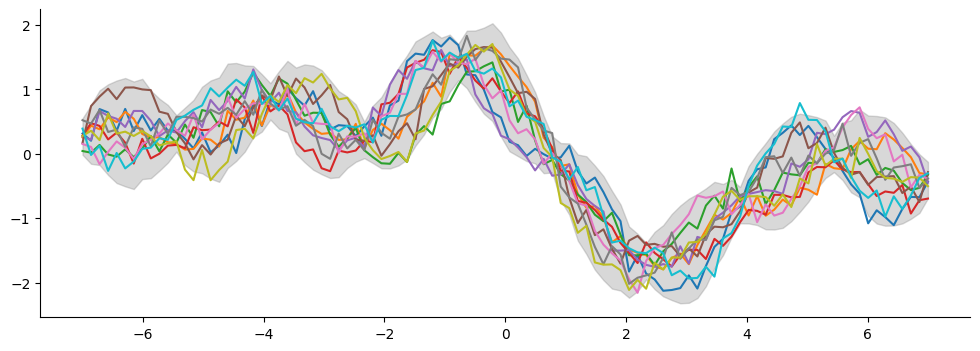

In [10]:
instance = GaussianProcess(kernel_func=GaussianProcess.squared_exponential_kernel, kernel_kwargs={"lengthscale": 1, "sigma_f": 1.0, "sigma_n": 0.1})
xtrain, xtest = np.linspace(-7, 7, 10), np.linspace(-7,7,100)
y1, _ = instance.get_prior_trajectories(X=xtrain, num_trajectories=1)
instance.fit(X=xtrain, y=y1)
ymean, vmean = instance.get_posterior_trajectories(
    X=xtest,
    num_trajectories=10,
    cholesky=True
)

plt.plot(xtest, ymean)
plt.fill_between(
    xtest,
    np.mean(ymean, axis=1) - 2 * vmean**0.5,
    np.mean(ymean, axis=1) + 2 * vmean**0.5,
    color="gray",
    alpha=0.3
)
plt.show()


### Matérn Kernel

The Matérn kernel is a generalization of the RBF kernel that allows for different degrees of smoothness. It is particularly useful when the underlying function is not as smooth as the functions generated by the RBF kernel. The Matérn kernel is defined as:

$$k(x, x') = \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\sqrt{2\nu}\frac{||x - x'||}{l}\right)^\nu K_\nu\left(\sqrt{2\nu}\frac{||x - x'||}{l}\right)$$

where $\nu$ is the smoothness parameter, $l$ is the length scale, $||x - x'||$ is the Euclidean distance between the input points $x$ and $x'$, and $K_\nu$ is the modified Bessel function of the second kind.

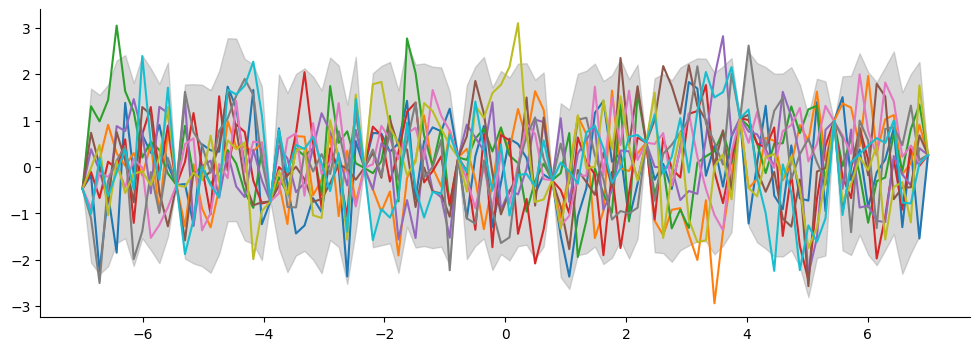

In [11]:
instance = GaussianProcess(kernel_func=GaussianProcess.matern_kernel, kernel_kwargs={"lengthscale": 1, "smoothness": 0.1, "sigma_n": 0.})
xtrain, xtest = np.linspace(-7, 7, 10), np.linspace(-7,7,100)
y1, _ = instance.get_prior_trajectories(X=xtrain, num_trajectories=1)
instance.fit(X=xtrain, y=y1)
ymean, vmean = instance.get_posterior_trajectories(
    X=xtest,
    num_trajectories=10,
    cholesky=True
)

plt.plot(xtest, ymean)
plt.fill_between(
    xtest,
    np.mean(ymean, axis=1) - 2 * vmean**0.5,
    np.mean(ymean, axis=1) + 2 * vmean**0.5,
    color="gray",
    alpha=0.3
)
plt.show()


### Exponential Kernel

The Exponential kernel is a simpler kernel function that generates less smooth functions compared to the RBF kernel. It is useful for modeling data with non-smooth relationships. The Exponential kernel is defined as:

$$k(x, x') = \sigma_f^2 \exp\left(-\frac{||x - x'||}{l}\right) + \sigma_n^2 \delta_{x, x'}$$

where $\sigma^2$ is the variance, $l$ is the length scale, and $||x - x'||$ is the Euclidean distance between the input points $x$ and $x'$.

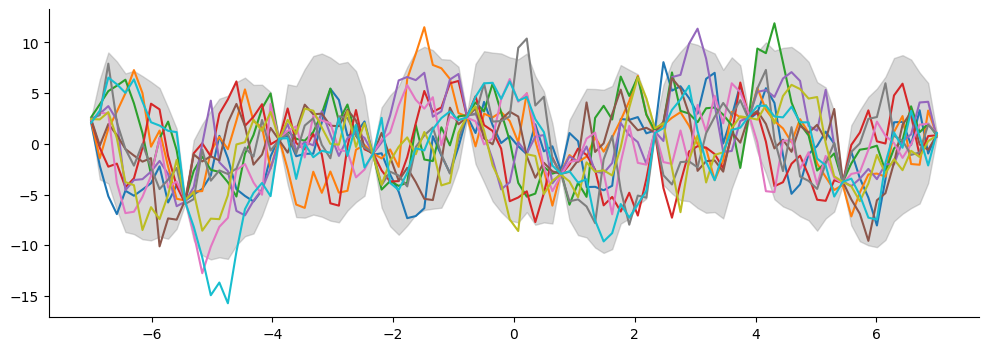

In [12]:
instance = GaussianProcess(kernel_func=GaussianProcess.exponential_kernel, kernel_kwargs={"lengthscale": 1, "sigma_f": 5.0, "sigma_n": 0.1})
xtrain, xtest = np.linspace(-7, 7, 10), np.linspace(-7,7,100)
y1, _ = instance.get_prior_trajectories(X=xtrain, num_trajectories=1)
instance.fit(X=xtrain, y=y1)
ymean, vmean = instance.get_posterior_trajectories(
    X=xtest,
    num_trajectories=10,
    cholesky=True
)

plt.plot(xtest, ymean)
plt.fill_between(
    xtest,
    np.mean(ymean, axis=1) - 2 * vmean**0.5,
    np.mean(ymean, axis=1) + 2 * vmean**0.5,
    color="gray",
    alpha=0.3
)
plt.show()


### Periodic Kernel

The Periodic kernel, also known as the Cosine kernel, is useful for modeling data with periodic patterns. It generates functions with a repeating pattern and is suitable for data with cyclical or seasonal trends. The Periodic kernel is defined as:

$$k(x, x') = \sigma_f^2 \exp\left(-\frac{2\sin^2(\frac{\pi||x - x'||}{P})}{l^2}\right) + \sigma_n^2 \delta_{x, x'}$$

where $\sigma^2$ is the variance, $l$ is the length scale, $||x - x'||$ is the Euclidean distance between the input points $x$ and $x'$, and $P$ is the period of the function.

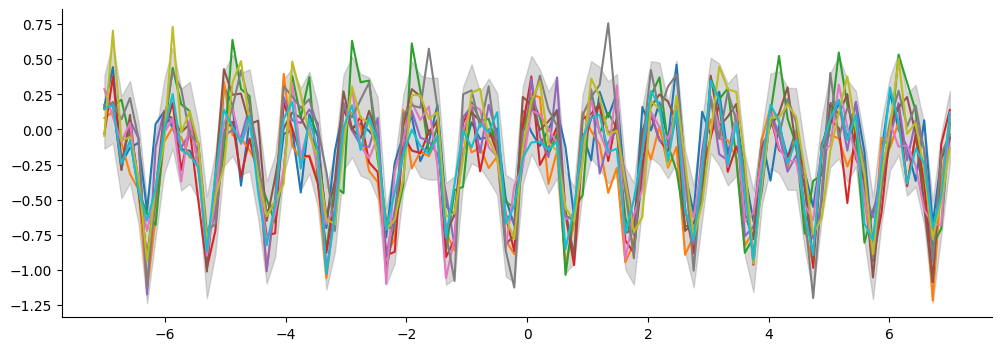

In [13]:
instance = GaussianProcess(kernel_func=GaussianProcess.periodic_kernel, kernel_kwargs={"lengthscale": 1, "sigma_f": .5, "sigma_n": 0.1})
xtrain, xtest = np.linspace(-7, 7, 10), np.linspace(-7,7,100)
y1, _ = instance.get_prior_trajectories(X=xtrain, num_trajectories=1)
instance.fit(X=xtrain, y=y1)
ymean, vmean = instance.get_posterior_trajectories(
    X=xtest,
    num_trajectories=10,
    cholesky=True
)

plt.plot(xtest, ymean)
plt.fill_between(
    xtest,
    np.mean(ymean, axis=1) - 2 * vmean**0.5,
    np.mean(ymean, axis=1) + 2 * vmean**0.5,
    color="gray",
    alpha=0.3
)
plt.show()

Understanding the properties of different kernel functions and their suitability for various types of data is crucial for applying Gaussian Processes effectively in machine learning tasks. 

It is also worth noting that kernel functions can be combined to create more complex covariance structures. For example, by adding or multiplying kernels, one can model data with multiple underlying patterns or trends. This enables Gaussian Processes to adapt to a wide range of real-world scenarios, making them a versatile tool for non-parametric regression and classification tasks.

In conclusion, selecting the right kernel function and tuning its hyperparameters is a critical aspect of using Gaussian Processes effectively. By understanding the properties and suitability of different kernel functions for various types of data, we can build powerful and flexible GP models that can capture complex relationships and provide meaningful uncertainty estimates for predictions.

#### Rasmussen & Williams (2006) Figure 2.5

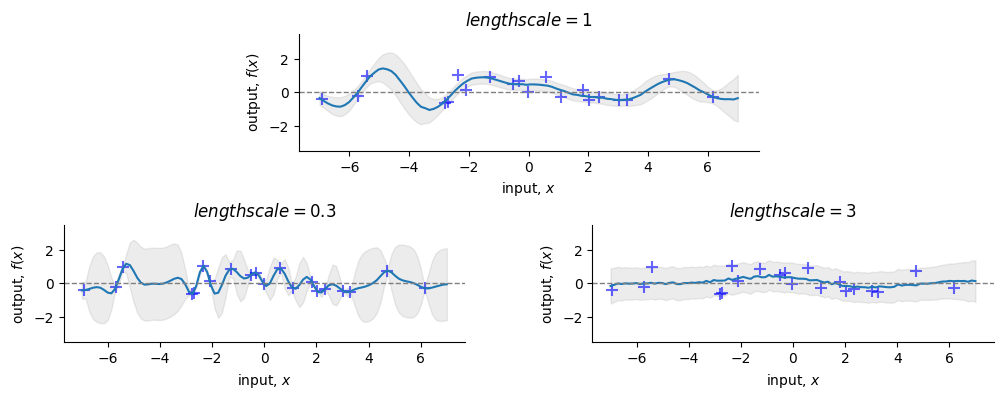

In [14]:
xtrain = np.random.uniform(-7, 7, 20)
xtest = np.linspace(-7, 7, 100)
# Get prior trajectory common to all three instances below 
y1, _ = instance.get_prior_trajectories(X=xtrain, num_trajectories=1)
# Create instances with specific kernel parameters
inst25a = GaussianProcess(kernel_kwargs={"lengthscale":1, "sigma_f":1, "sigma_n":0.1})
inst25b = GaussianProcess(kernel_kwargs={"lengthscale":0.3, "sigma_f":1.08, "sigma_n":5e-05})
inst25c = GaussianProcess(kernel_kwargs={"lengthscale":3.0, "sigma_f":1.16, "sigma_n":0.29})
# Fit each instance using the prior trajectory and training inputs
inst25a.fit(xtrain, y1)
inst25b.fit(xtrain, y1)
inst25c.fit(xtrain, y1)
# Get posterior trajectories for each of three configurations
y25a, v25a = inst25a.get_posterior_trajectories(X=xtest, num_trajectories=100, cholesky=True)
y25b, v25b = inst25b.get_posterior_trajectories(X=xtest, num_trajectories=100, cholesky=True)
y25c, v25c = inst25c.get_posterior_trajectories(X=xtest, num_trajectories=100, cholesky=True)
# Second Figure 2.5
fig25(
    xtrain, y1, xtest, 
    np.mean(y25a,axis=1), np.mean(y25b, axis=1), np.mean(y25c,axis=1), 
    v25a, v25b, v25c, 
    suptitle="fig25abc_v2"
)


## Mathematical reasoning
These details are extracted from Rasmussen & Williams 2006. Refer to the book for a more complete explanation.

DATA $: \mathcal{D}=\left\{\left(\mathbf{x}_i, y_i\right)\right\}_{i=1}^N$

**Objective**: provide predictive distributions on test points $\left\{\mathbf{x}_i^*\right\}_{i=1}^M$

Assume noisy observations of some true function $f(\mathbf{x})$ :
$$
y_i=f\left(\mathbf{x}_i\right)+\epsilon_i \quad \epsilon_i \sim \mathcal{N}\left(0, \sigma_\epsilon^2\right)
$$
Collect everything into matrices/vectors : $\mathbf{X}, \mathbf{X}^*, \mathbf{y}, \mathbf{f}, \mathbf{f}^*$

Let $\mathbf{K}_{\mathbf{X}, \mathbf{X}}$ be an $N$-by- $N$ matrix of all similarities $\mathcal{K}\left(\mathbf{x}_i, \mathbf{x}_j \mid \boldsymbol{\tau}\right)$.

Gaussian Process Assumption : $\mathbf{f}$ and $\mathbf{f}^*$ are distributed as an $(N+M)$-dimensional multivariate Normal :
$$
\left[\begin{array}{c}
\mathbf{f} \\
\mathbf{f}^*
\end{array}\right] \sim \mathcal{N}\left(\left[\begin{array}{l}
\mathbf{0} \\
\mathbf{0}
\end{array}\right],\left[\begin{array}{cc}
\hat{\mathbf{K}}_{\mathbf{X}, \mathbf{X}} & \mathbf{K}_{\mathbf{X}, \mathbf{X}^*} \\
\mathbf{K}_{\mathbf{X}, \mathbf{X}} & \mathbf{K}_{\mathbf{X}^*, \mathbf{X}^*}
\end{array}\right]\right)
$$
where $\hat{\mathbf{K}}_{\mathbf{X}, \mathbf{X}}=\mathbf{K}_{\mathbf{X}, \mathbf{X}}+\sigma_\epsilon^2 \mathbf{I}$

The posterior distribution over $\mathbf{f}^*$ comes from conditioning:

$$
\begin{aligned}
\mathbf{f}^* \mid X^*, X, & \mathbf{f} \sim \mathcal{N}( \\
    & \mathbf{K}_{\mathbf{X}^*, \mathbf{X}} \mathbf{K}_{\mathbf{X}, \mathbf{X}}^{-1} \mathbf{f}, \\
    & \mathbf{K}_{\mathbf{X}^*, \mathbf{X}^*}-\mathbf{K}_{\mathbf{X}^*, \mathbf{X}} \mathbf{K}_{\mathbf{X}, \mathbf{X}}^{-1} \mathbf{K}_{\mathbf{X}, \mathbf{X}^*}\\ 
    & )
\end{aligned}
$$
## Conclusion

In this notebook, we have explored Gaussian Processes and their use in machine learning. We have discussed the role of kernel functions in shaping the behavior of GPs and replicated Figures 2.2 and 2.5 from Rasmussen & Williams' book "Gaussian Processes for Machine Learning" (2006).

Understanding the choice of kernel function and its impact on the Gaussian Process is crucial for applying GPs effectively in machine learning tasks. As you explore further, you can experiment with different kernel functions and their hyperparameters to see how they affect the behavior of the Gaussian Process and the quality of predictions made by the model.

## Notes
- HyperBO for pre-trained GPs https://github.com/google-research/hyperbo
- SMAC for specific hyperparameter finetuning https://github.com/automl/SMAC3